**Required Libarries**

In [ ]:
!pip install -q openpyxl xlrd pillow
!pip install gdown
## Dataset from hugging-face
!pip install datasets
!pip install huggingface_hub
!pip install torch torchvision


In [ ]:
# --- SYSTEM & UTILS ---
import os
import warnings
import numpy as np
import pandas as pd
from functools import reduce

# --- IMAGE PROCESSING ---
# Critical: This fixes your NameError
from PIL import Image
import cv2  # Kept as backup, though we are using PIL now

# --- PLOTTING ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- PYTORCH & DL ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# --- SKLEARN (METRICS & SPLITS) ---
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GroupShuffleSplit

# --- PROGRESS TRACKING ---
from tqdm.auto import tqdm # Automatically selects notebook/console widget

# --- HUGGING FACE (If you are downloading data) ---
import zipfile
from datasets import load_dataset
from huggingface_hub import login, hf_hub_download

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


**[Take Our Dataset from HuggingFace](https://huggingface.co/datasets/0xkhass/Sheep_Dataset)**

In [ ]:
zip_path = hf_hub_download(
    repo_id="0xkhass/Sheep_Dataset",
    filename="Ai_project.zip",
    repo_type="dataset",  # important
    
)

extract_dir = "Sheep_Dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Dataset extracted to: {extract_dir}")



Ai_project.zip:   0%|          | 0.00/2.16G [00:00<?, ?B/s]

Dataset extracted to: Sheep_Dataset


**CONFIGS**


In [ ]:
BASE_PATH = '/content/Sheep_Dataset/Ai_project/pregnancy and age'
MASTER_DATASET_PATH = '/content/sheep_master_dataset.xlsx'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device : {DEVICE}")

# Image Folder Paths
IMAGE_PATHS = {
    'Weaning_Side': f'{BASE_PATH}/Weaning/Side images/Side Result',
    'Weaning_Side2': f'{BASE_PATH}/Weaning/Side images/Side Result2',
    'Weaning_Top': f'{BASE_PATH}/Weaning/Top images/Top result',
    'Weaning_Top2': f'{BASE_PATH}/Weaning/Top images/Top-result2',
    'Premating_Side_D1': f'{BASE_PATH}/pre-mating/Side images/Day 1',
    'Premating_Side_D2': f'{BASE_PATH}/pre-mating/Side images/Day2',
    'Premating_Top_D1': f'{BASE_PATH}/pre-mating/Top images/D1',
    'Premating_Top_D2': f'{BASE_PATH}/pre-mating/Top images/D2',
}

# Hyperparams
IMG_SIZE = 224
BATCH_SIZE = 32
LR = 0.0005
EPOCHS = 50
WEIGHT_DECAY = 1e-4


 Using device : cuda


**HELPER FUNCTIONS**

In [ ]:
def clean_single_id(val):
    """Safely converts messy inputs (13.0, '13.JPG') into a Clean Integer ID."""
    if pd.isna(val) or val == '': return np.nan
    s = str(val).strip().upper()
    if '.' in s:
        base, ext = os.path.splitext(s)
        if ext in ['.JPG', '.JPEG', '.PNG', '.BMP']: s = base
    s = s.replace('_', '').replace('-', '')
    try:
        return int(float(s))
    except ValueError:
        return np.nan

Start ......

In [ ]:
print(f"Loading Master Dataset from: {MASTER_DATASET_PATH}")
if os.path.exists(MASTER_DATASET_PATH):
    master_df = pd.read_excel(MASTER_DATASET_PATH)

    # Standardize ID
    master_df['clean_id'] = master_df['Ewe_ID'].apply(clean_single_id)

    # Clean up (remove empty IDs and the 6 ghost rows we found earlier)
    master_df = master_df.dropna(subset=['clean_id'])
    master_df['clean_id'] = master_df['clean_id'].astype(int)

    print(f"Master Data Loaded: {len(master_df)} biological records.")
    print("Stages present:", master_df['Stage'].unique())
else:
    raise FileNotFoundError(f"Could not find {MASTER_DATASET_PATH}. Please upload the file.")

Loading Master Dataset from: /content/sheep_master_dataset.xlsx
Master Data Loaded: 171 biological records.
Stages present: ['Weaning' 'PreMating']


**MAP IMAGES**

In [ ]:
image_map = []
valid_ids = set(master_df['clean_id'])

print(f"\nScanning {len(IMAGE_PATHS)} image folders...")

for folder_key, path in IMAGE_PATHS.items():
    if os.path.exists(path):
        files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Determine Biological Stage based on Folder Name
        # This is CRITICAL: Weaning images must match Weaning rows
        if 'Weaning' in folder_key:
            current_stage = 'Weaning'
        elif 'Premating' in folder_key or 'pre-mating' in folder_key:
            current_stage = 'PreMating' # Must match exact spelling in Excel
        else:
            current_stage = 'Unknown'

        for f in files:
            c_id = clean_single_id(f)

            # Check if this sheep exists in our Excel file
            if pd.notna(c_id) and c_id in valid_ids:
                image_map.append({
                    'clean_id': c_id,
                    'Stage': current_stage,     # Link image to specific stage
                    'image_path': os.path.join(path, f),
                    'view_type': folder_key     # Keep track of camera angle
                })
    else:
        print(f"Warning: Folder not found: {path}")

print(f"Found {len(image_map)} valid images.")


Scanning 8 image folders...
Found 386 valid images.


In [ ]:
# --- 3. FINAL MERGE ---
if len(image_map) > 0:
    img_df = pd.DataFrame(image_map)

    # MAGIC MERGE: We join on BOTH 'clean_id' AND 'Stage'
    # This prevents a Weaning image from accidentally matching a PreMating weight
    final_dataset = pd.merge(img_df, master_df, on=['clean_id', 'Stage'], how='inner')


    # Map letters to numbers so the model can understand them
    size_mapping = {'S': 0, 'M': 1, 'L': 2}
    # Apply the mapping
    final_dataset['Size'] = final_dataset['Size'].map(size_mapping)

    # fill any missing values with the average (Medium = 1) just in case
    final_dataset['Size'] = final_dataset['Size'].fillna(1)

    print("'Size' column converted to numbers:")
    print(final_dataset['Size'].value_counts())


    print(f"FINAL DATASET READY: {len(final_dataset)} samples")

    # Display breakdown
    print("\nBreakdown by Stage:")
    print(final_dataset['Stage'].value_counts())

    print("\nColumns available for training:")
    print(list(final_dataset.columns))

    # --- 1. Fix Missing Values in BCS ---
    # Calculate the average BCS (excluding NaNs)
    mean_bcs = final_dataset['BCS'].mean()

    # Fill the NaNs
    final_dataset['BCS'] = final_dataset['BCS'].fillna(mean_bcs)

    print(f"Filled missing BCS values with average: {mean_bcs:.2f}")



    # Save for sanity check
    # final_dataset.to_csv('debug_dataset_ready_for_loader.csv', index=False)
else:
    print("ERROR: No images matched the Excel IDs.")

'Size' column converted to numbers:
Size
1.0    182
0.0    102
2.0    100
Name: count, dtype: int64
FINAL DATASET READY: 384 samples

Breakdown by Stage:
Stage
Weaning      216
PreMating    168
Name: count, dtype: int64

Columns available for training:
['clean_id', 'Stage', 'image_path', 'view_type', 'Ewe_ID', 'Weight_kg', 'CT_Carcass_kg', 'Fat_kg', 'Lean_kg', 'Bone_kg', 'BCS', 'Size', 'LW_M_Ratio', 'M_F_Ratio', 'M_B_Ratio', 'Muscle_Hindquarter', 'Muscle_Loin', 'Muscle_Shoulder', 'Muscle_Yield']
Filled missing BCS values with average: 2.77


In [ ]:
print(final_dataset)

# **PyTorch Dataset class**
*What it does ?*

-------------
Handles loadings images and tabular data مع بعض

In [ ]:
class SheepDataset(Dataset):
    def __init__(self, df, tabular_input_cols, target_cols, transform=None,
                 input_scaler=None, target_scaler=None, is_train=False):

        self.df = df.reset_index(drop=True)
        self.tabular_cols = tabular_input_cols
        self.target_cols = target_cols
        self.transform = transform
        self.images = [] # The RAM Cache

        # --- 1. PRE-LOAD ALL IMAGES ---
        print(f"Loading {len(self.df)} images into RAM...")
        if  not self.images or len(self.df) < 0:
          for idx in range(len(self.df)):
              try:
                  # Load and keep in memory
                  img = Image.open(self.df.iloc[idx]['image_path']).convert('RGB')
                  img.load() # Force load pixel data
                  self.images.append(img)
              except:
                  self.images.append(Image.new('RGB', (224, 224), (0, 0, 0)))
          print("✅ Images Loaded!")

        # --- 2. Handle TABULAR INPUTS ---
        if self.tabular_cols:
            raw_tab = self.df[self.tabular_cols].values.astype(np.float32)
            if is_train:
                self.input_scaler = StandardScaler()
                self.tabular_data = self.input_scaler.fit_transform(raw_tab)
            elif input_scaler:
                self.input_scaler = input_scaler
                self.tabular_data = self.input_scaler.transform(raw_tab)
            else:
                self.input_scaler = StandardScaler()
                self.tabular_data = self.input_scaler.fit_transform(raw_tab)
        else:
            self.tabular_data = None
            self.input_scaler = None

        # --- 3. Handle TARGETS ---
        if self.target_cols:
            targets_raw = self.df[self.target_cols].values.astype(np.float32)
            if is_train:
                self.target_scaler = StandardScaler()
                self.target_scaled = self.target_scaler.fit_transform(targets_raw)
            elif target_scaler:
                self.target_scaler = target_scaler
                self.target_scaled = self.target_scaler.transform(targets_raw)
            else:
                self.target_scaler = StandardScaler()
                self.target_scaled = self.target_scaler.fit_transform(targets_raw)
        else:
            self.target_scaled = None
            self.target_scaler = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # FAST: Get from list, no disk read
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        if self.tabular_data is not None:
            tab_features = torch.tensor(self.tabular_data[idx], dtype=torch.float32)
        else:
            tab_features = torch.tensor([], dtype=torch.float32)

        if self.target_scaled is not None:
            target = torch.tensor(self.target_scaled[idx], dtype=torch.float32)
        else:
            target = torch.tensor([], dtype=torch.float32)

        return image, tab_features, target, str(self.df.iloc[idx]['clean_id'])

    def get_scalers(self):
        return self.input_scaler, self.target_scaler

In [ ]:
# TRANFORMS FOR REGRESSION
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    # We use Resize((224, 224)) instead of CenterCrop
    # This ensures we see the WHOLE sheep, even if it's slightly distorted.
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# --- DEFINE COLUMNS ---
UNIFIED_TARGETS = ['Weight_kg', 'Lean_kg', 'Fat_kg', 'CT_Carcass_kg']
# Define Input/Output Columns
TABULAR_COLS = ['BCS', 'Size'] # Using BCS and Size as auxiliary inputs
TARGET_COLS = UNIFIED_TARGETS


# Split Data (80% Train, 20% Val)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(final_dataset, groups=final_dataset['clean_id']))

train_df = final_dataset.iloc[train_idx].reset_index(drop=True)
val_df   = final_dataset.iloc[val_idx].reset_index(drop=True)

# Create Dataset Objects
# Note: transform logic was defined in previous cells (train_transforms, val_transforms)
train_dataset = SheepDataset(
    train_df,
    tabular_input_cols=TABULAR_COLS,
    target_cols=UNIFIED_TARGETS,
    transform=train_transforms,
    is_train=True
)

# Use scalers from training set for validation set to prevent leakage
val_dataset = SheepDataset(
    val_df,
    tabular_input_cols=TABULAR_COLS,
    target_cols=TARGET_COLS,
    transform=val_transforms,
    input_scaler=train_dataset.input_scaler,
    target_scaler=train_dataset.target_scaler,
    is_train=False
)
print(f"Dataset created with {len(train_dataset)} samples.")
print(f"Input features: {TABULAR_COLS}")
print(f"Targets: {TARGET_COLS}")

Loading 307 images into RAM...
✅ Images Loaded!
Loading 77 images into RAM...
✅ Images Loaded!
Dataset created with 307 samples.
Input features: ['BCS', 'Size']
Targets: ['Weight_kg', 'Lean_kg', 'Fat_kg', 'CT_Carcass_kg']


# **BEFORE AND AFTER IMAGE TRANSFORMATION**

In [ ]:
def show_preprocessing_steps(image_path, n_augmented=4):
    """
    Visualization updated to handle PIL/Numpy conversion correctly.
    """
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")
        return

    # Load as PIL for Transforms (matches Dataset logic)
    img_pil = Image.open(image_path).convert('RGB')
    img_np = np.array(img_pil) # For plotting

    # ============================================
    # FIGURE: Data Augmentation Examples
    # ============================================
    fig, axes = plt.subplots(2, n_augmented + 1, figsize=(3 * (n_augmented + 1), 6))

    # Original
    axes[0, 0].imshow(img_np)
    axes[0, 0].set_title('Original', fontsize=10)
    axes[0, 0].axis('off')

    axes[1, 0].imshow(img_np)
    axes[1, 0].set_title('Original', fontsize=10)
    axes[1, 0].axis('off')

    # Training Augmentations
    for i in range(n_augmented):
        # Apply transform to PIL
        aug_tensor = train_transforms(img_pil)

        # Denormalize for Viz
        img_aug = aug_tensor.permute(1, 2, 0).numpy()
        img_aug = img_aug * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_aug = np.clip(img_aug, 0, 1)

        axes[0, i + 1].imshow(img_aug)
        axes[0, i + 1].set_title(f'Train Aug #{i+1}', fontsize=10)
        axes[0, i + 1].axis('off')

    # Validation Transform
    for i in range(n_augmented):
        val_tensor = val_transforms(img_pil)

        img_val = val_tensor.permute(1, 2, 0).numpy()
        img_val = img_val * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_val = np.clip(img_val, 0, 1)

        axes[1, i + 1].imshow(img_val)
        axes[1, i + 1].set_title(f'Val Pipeline', fontsize=10)
        axes[1, i + 1].axis('off')

    plt.suptitle('Data Augmentation Check', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_before_after_grid(df, n_samples=4):
    """
    Show before/after for multiple images in a grid using PIL to match Training logic.
    """
    # Safe sampling
    n_samples = min(n_samples, len(df))
    if n_samples == 0: return

    sample_indices = np.random.choice(len(df), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4 * n_samples))
    # Handle single sample case (axes is 1D array)
    if n_samples == 1: axes = axes.reshape(1, -1)

    for idx, sample_idx in enumerate(sample_indices):
        row = df.iloc[sample_idx]
        img_path = row['image_path']

        # 1. Load as PIL (Matches Dataset Class)
        try:
            img_pil = Image.open(img_path).convert('RGB')
        except:
            continue

        # 2. Original
        axes[idx, 0].imshow(img_pil)
        axes[idx, 0].set_title(f'Original\nID: {row["clean_id"]}', fontsize=10)
        axes[idx, 0].axis('off')

        # 3. After Validation Transform (Resize + Crop)
        # Note: We simulate the transform steps for visualization
        val_tensor = val_transforms(img_pil)
        img_val = val_tensor.permute(1, 2, 0).numpy()
        img_val = img_val * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_val = np.clip(img_val, 0, 1)

        axes[idx, 1].imshow(img_val)
        axes[idx, 1].set_title('Validation Input\n(224x224)', fontsize=10)
        axes[idx, 1].axis('off')

        # 4. After Training Transform (Augmented)
        train_tensor = train_transforms(img_pil)
        img_train = train_tensor.permute(1, 2, 0).numpy()
        img_train = img_train * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_train = np.clip(img_train, 0, 1)

        axes[idx, 2].imshow(img_train)
        axes[idx, 2].set_title('Training Input\n(Augmented)', fontsize=10)
        axes[idx, 2].axis('off')

    plt.suptitle('Preprocessing Verification', fontsize=16, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_augmentation_effects():
    """
    Show individual augmentation effects on a single sample
    """
    if len(final_dataset) == 0: return

    sample_path = final_dataset.iloc[0]['image_path']
    img_pil = Image.open(sample_path).convert('RGB')

    # Resize for better visibility before applying augs
    img_pil = transforms.Resize((IMG_SIZE, IMG_SIZE))(img_pil)

    # Define specific augs to test
    augmentations = {
        'Original': transforms.Compose([]),
        'Horizontal Flip': transforms.RandomHorizontalFlip(p=1.0),
        'Rotation (20°)': transforms.RandomRotation(20), # Sheep don't flip upside down!
        'Color Jitter': transforms.ColorJitter(brightness=0.4, contrast=0.4),
        'Random Crop': transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 0.9)),
        'Affine': transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    }

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()

    for idx, (name, aug) in enumerate(augmentations.items()):
        if idx >= len(axes): break

        # Apply aug
        img_aug = aug(img_pil)

        axes[idx].imshow(img_aug)
        axes[idx].set_title(name, fontsize=10, fontweight='bold')
        axes[idx].axis('off')

    plt.suptitle('Individual Augmentation Tests', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

 IMAGE PREPROCESSING VISUALIZATION 

Using sample image: /content/Sheep_Dataset/Ai_project/pregnancy and age/Weaning/Side images/Side Result/2566.JPG

1.  Preprocessing Pipeline Steps:


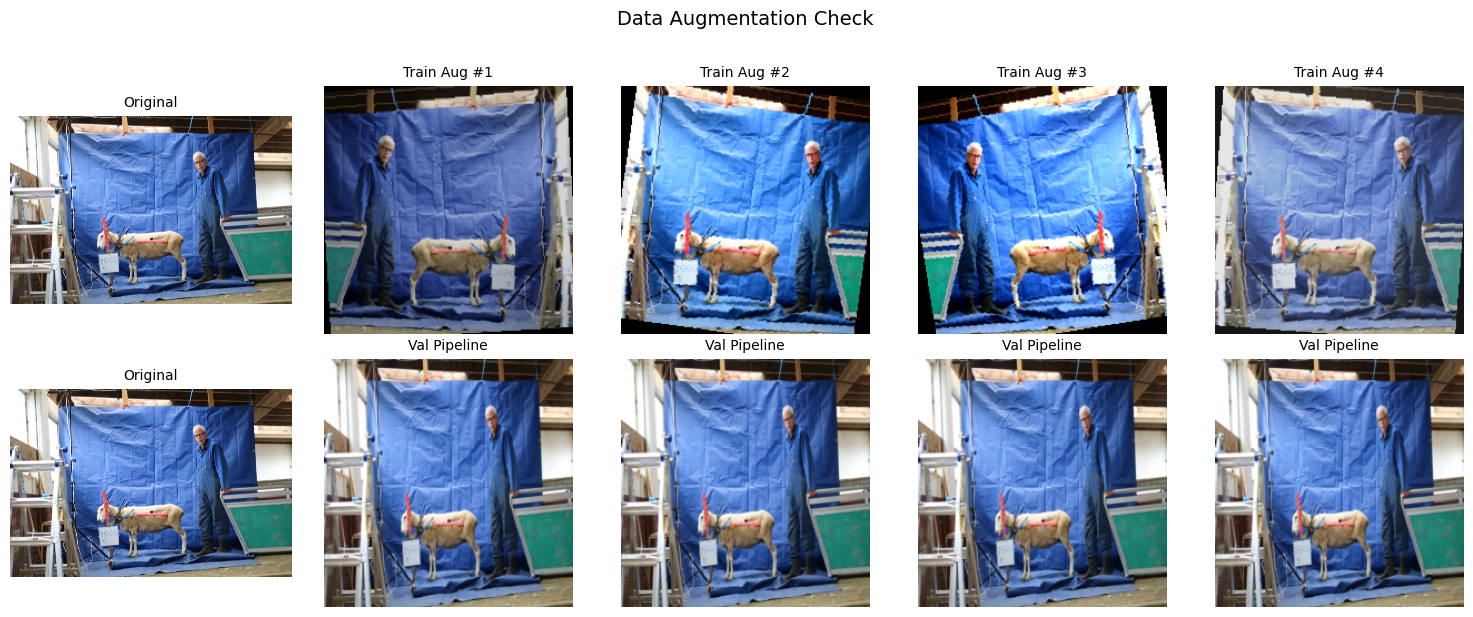


2. Before/After Grid (Multiple Samples):


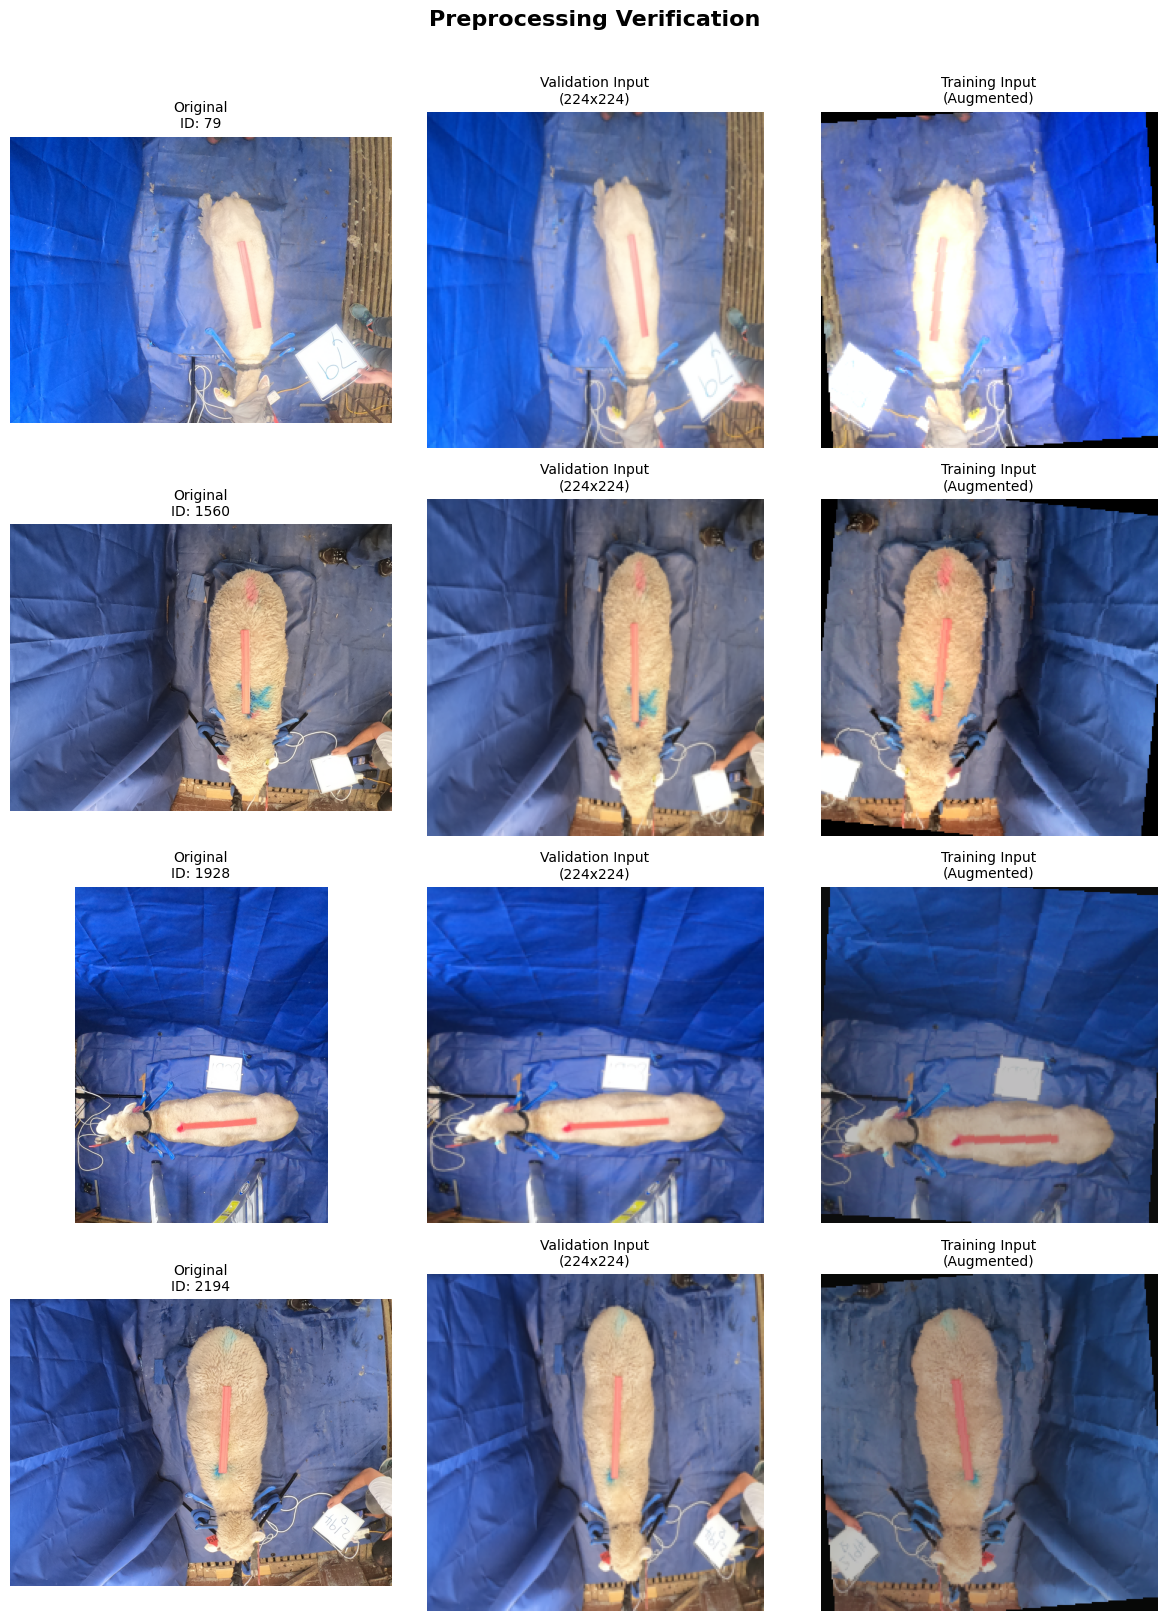


3. Individual Augmentation Effects:


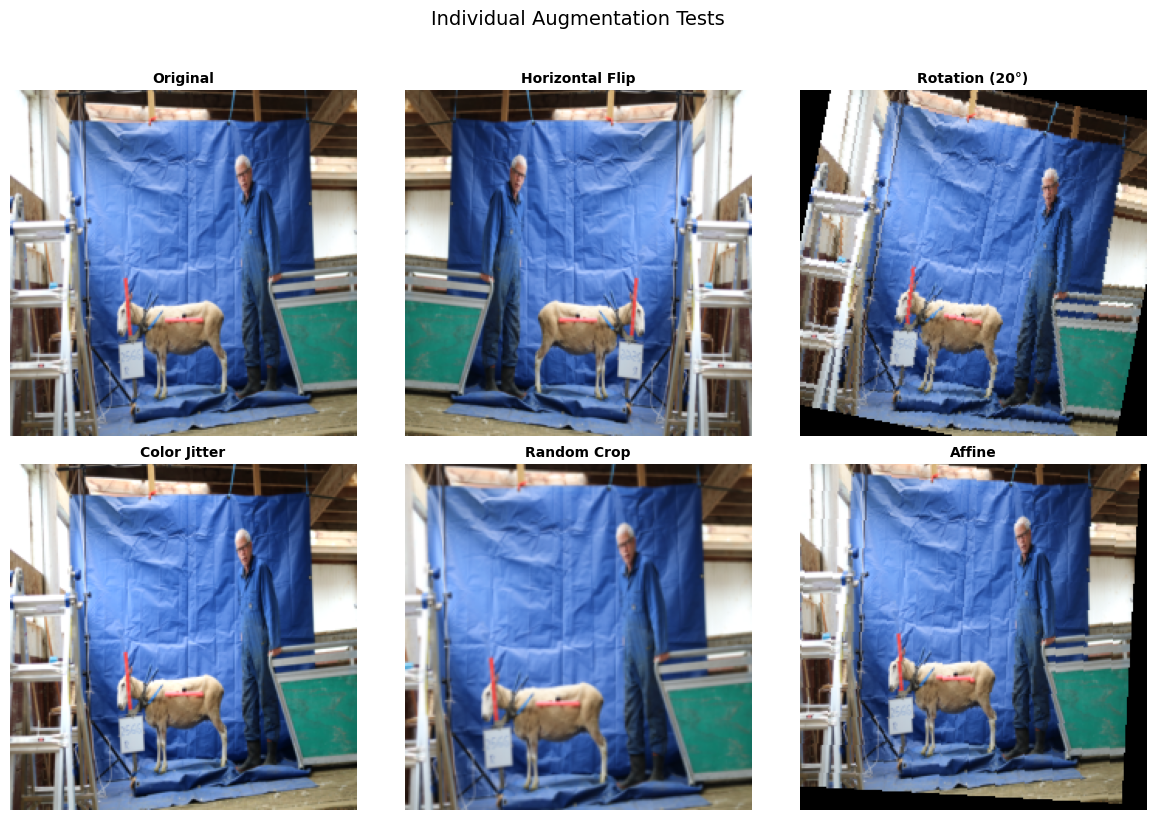


Preprocessing visualization complete!


In [ ]:
print(" IMAGE PREPROCESSING VISUALIZATION ")
# Get a sample image path
sample_image = final_dataset.iloc[0]['image_path']
print(f"\nUsing sample image: {sample_image}\n")

# Show preprocessing pipeline
print("1.  Preprocessing Pipeline Steps:")
show_preprocessing_steps(sample_image)

# Show before/after grid for multiple images
print("\n2. Before/After Grid (Multiple Samples):")
show_before_after_grid(final_dataset, n_samples=4)

# Show individual augmentation effects
print("\n3. Individual Augmentation Effects:")
show_augmentation_effects()

print("\nPreprocessing visualization complete!")

In [ ]:
class SheepHybridModel(nn.Module):
    def __init__(self, num_tabular_features=2, num_targets=4):
        super(SheepHybridModel, self).__init__()

        # A. IMAGE BRANCH (ResNet18)
        # We use ResNet18 because ResNet50 is too big for 180 images (will overfit)
        self.cnn = models.resnet18(weights='IMAGENET1K_V1')

        # Freeze early layers (Stages 1-3) to preserve edge detectors
        # This is crucial for small datasets!
        for param in self.cnn.parameters():
            param.requires_grad = False

        # Unfreeze ONLY Layer 4 (High level features)
        for param in self.cnn.layer4.parameters():
            param.requires_grad = True

        # Remove original Head
        self.cnn.fc = nn.Identity()

        # B. TABULAR BRANCH (Size + BCS)
        self.tab_mlp = nn.Sequential(
            nn.Linear(num_tabular_features, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU()
        )

        # C. FUSION HEAD (Concatenate Image Features + Tabular Features)
        # ResNet18 outputs 512 features. Tabular outputs 32. Total = 544.
        self.final_head = nn.Sequential(
            nn.Linear(512 + 32, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4), # Increased Dropout to prevent overfitting
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_targets)
        )

    def forward(self, image, tab_data):
        # 1. Image Path
        x_img = self.cnn(image)
        x_img = torch.flatten(x_img, 1) # Flatten (Batch, 512)

        # 2. Tabular Path
        x_tab = self.tab_mlp(tab_data)

        # 3. Fusion
        combined = torch.cat((x_img, x_tab), dim=1)
        output = self.final_head(combined)
        return output

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0

In [ ]:
def get_warmup_lr(epoch, base_lr, warmup_epochs=3):
    """Learning rate warmup"""
    if epoch < warmup_epochs:
        return base_lr * (epoch + 1) / warmup_epochs
    return base_lr

def train_model(model, train_loader, val_loader, epochs, lr, device):
    # Weights for Loss (Optional: Give more weight to Fat/Lean if they are harder)
    criterion = nn.MSELoss()

    # Optimizer: Train ONLY parameters that require grad (Layer4 + Head)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                           lr=lr, weight_decay=0.01)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    early_stopping = EarlyStopping(patience=12, min_delta=0.001)

    train_history, val_history = [], []

    for epoch in range(epochs):
        # Train
        model.train()
        run_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Ep {epoch+1}/{epochs}", leave=False)

        for imgs, tabs, targets, _ in pbar:
            imgs, tabs, targets = imgs.to(device), tabs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, tabs) # Hybrid Forward Pass
            loss = criterion(outputs, targets)
            loss.backward()

            # Clip Gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            run_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        avg_train = run_loss / len(train_loader)
        train_history.append(avg_train)

        # Validate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, tabs, targets, _ in val_loader:
                imgs, tabs, targets = imgs.to(device), tabs.to(device), targets.to(device)
                outputs = model(imgs, tabs)
                val_loss += criterion(outputs, targets).item()

        avg_val = val_loss / len(val_loader)
        val_history.append(avg_val)

        print(f"Epoch {epoch+1}: Train={avg_train:.4f} | Val={avg_val:.4f} | LR={optimizer.param_groups[0]['lr']:.6f}")

        scheduler.step(avg_val)
        early_stopping(avg_val, model)

        if early_stopping.early_stop:
            print("🛑 Early Stopping Triggered")
            break

    # Load best model
    model.load_state_dict(early_stopping.best_model_state)
    return model, train_history, val_history

In [ ]:
# --- 1. PREPARE DATA SPLITS & DATASETS ---
print(f"Training on Unified Targets: {TABULAR_COLS}")
print(f"Train Samples: {len(train_df)} | Val Samples: {len(val_df)}")

# Create DataLoaders
print("Setting up DataLoaders...")
train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataset_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 2. INITIALIZE MODEL ---
# Tabular Features = 2 (BCS + Size)
# Targets = len(TARGET_COLS)
model = SheepHybridModel(num_tabular_features=len(TABULAR_COLS), num_targets=len(TARGET_COLS))
model = model.to(DEVICE)

# --- 3. RUN TRAINING ---
print("STARTING TRAINING...")
trained_model, t_hist, v_hist = train_model(
    model,
    train_dataset_loader,
    val_dataset_loader,
    epochs=EPOCHS,
    lr=LR,
    device=DEVICE
)

# Save the model after training
torch.save(trained_model.state_dict(), 'Final_Sheep_Hybrid_Model.pth')
print("Model Saved to 'Final_Sheep_Hybrid_Model.pth'")

Training on Unified Targets: ['BCS', 'Size']
Train Samples: 307 | Val Samples: 77
Setting up DataLoaders...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 72.4MB/s]


🚀 STARTING TRAINING...


Ep 1/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train=1.0077 | Val=0.4882 | LR=0.000500


Ep 2/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: Train=0.9329 | Val=0.5841 | LR=0.000500


Ep 3/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: Train=0.7912 | Val=0.4328 | LR=0.000500


Ep 4/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: Train=0.6146 | Val=0.9300 | LR=0.000500


Ep 5/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5: Train=0.5465 | Val=0.5048 | LR=0.000500


Ep 6/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6: Train=0.4653 | Val=0.3624 | LR=0.000500


Ep 7/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7: Train=0.3884 | Val=0.2925 | LR=0.000500


Ep 8/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8: Train=0.3828 | Val=0.3141 | LR=0.000500


Ep 9/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9: Train=0.3858 | Val=0.3298 | LR=0.000500


Ep 10/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10: Train=0.3292 | Val=0.3135 | LR=0.000500


Ep 11/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11: Train=0.3630 | Val=0.2606 | LR=0.000500


Ep 12/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12: Train=0.2908 | Val=0.3691 | LR=0.000500


Ep 13/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13: Train=0.2938 | Val=0.3209 | LR=0.000500


Ep 14/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14: Train=0.2142 | Val=0.3048 | LR=0.000500


Ep 15/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15: Train=0.2351 | Val=0.3997 | LR=0.000500


Ep 16/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16: Train=0.2315 | Val=0.3377 | LR=0.000500


Ep 17/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17: Train=0.2505 | Val=0.3486 | LR=0.000500


Ep 18/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18: Train=0.2380 | Val=0.3106 | LR=0.000250


Ep 19/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19: Train=0.2051 | Val=0.2933 | LR=0.000250


Ep 20/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20: Train=0.1727 | Val=0.2662 | LR=0.000250


Ep 21/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21: Train=0.1494 | Val=0.2892 | LR=0.000250


Ep 22/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22: Train=0.1895 | Val=0.3161 | LR=0.000250


Ep 23/50:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23: Train=0.1477 | Val=0.2831 | LR=0.000250
🛑 Early Stopping Triggered
💾 Model Saved to 'Final_Sheep_Hybrid_Model.pth'


In [ ]:
def comprehensive_evaluation(model, loader, scaler, target_names, device, is_hybrid=True):
    model.eval()
    preds_list = []
    targets_list = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            imgs, tabs, targets, _ = batch
            imgs = imgs.to(device)
            targets = targets.numpy() # Keep targets on CPU for sklearn

            # --- CRITICAL FIX: Pass both Image AND Tabular Data ---
            if is_hybrid:
                tabs = tabs.to(device)
                outputs = model(imgs, tabs)
            else:
                outputs = model(imgs)

            preds_list.append(outputs.cpu().numpy())
            targets_list.append(targets)

    # Concatenate & Inverse Transform
    preds_scaled = np.vstack(preds_list)
    targets_scaled = np.vstack(targets_list)

    preds_real = scaler.inverse_transform(preds_scaled)
    targets_real = scaler.inverse_transform(targets_scaled)

    # Calculate Metrics
    metrics = {}
    for i, name in enumerate(target_names):
        y_true = targets_real[:, i]
        y_pred = preds_real[:, i]

        # Guard against division by zero
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100

        metrics[name] = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'R2': r2_score(y_true, y_pred),
            'MAPE': mape
        }

    return preds_real, targets_real, metrics

In [ ]:
print("VALIDATION SET EVALUATION (Hybrid Model)")

pred_val, actual_val, metrics_val = comprehensive_evaluation(
    model=trained_model,
    loader=val_dataset_loader,
    scaler=train_dataset.target_scaler,   # SAME scaler used in training
    target_names=TARGET_COLS,              # 4 targets
    device=DEVICE,
    is_hybrid=True
)

# Metrics table
metrics_df = pd.DataFrame(metrics_val).T
print("\nPerformance Metrics (Validation):")
print(metrics_df.round(4))

# Summary
print("\nSummary Statistics:")
print(f"Average R²:  {metrics_df['R2'].mean():.4f}")
print(f"Average MAE: {metrics_df['MAE'].mean():.4f}")


print("\nTRAINING SET EVALUATION")

pred_train, actual_train, metrics_train = comprehensive_evaluation(
    model=trained_model,
    loader=train_dataset_loader,
    scaler=train_dataset.target_scaler,   # ✅ same scaler
    target_names=TARGET_COLS,
    device=DEVICE,
    is_hybrid=True
)

metrics_train_df = pd.DataFrame(metrics_train).T
print("\nTraining Metrics:")
print(metrics_train_df.round(4))


print("\nGENERALIZATION GAP (Train R² - Val R²):")

comparison = pd.DataFrame({
    'Train_R2': metrics_train_df['R2'],
    'Val_R2': metrics_df['R2'],
    'Gap': metrics_train_df['R2'] - metrics_df['R2']
})

print(comparison.round(4))


VALIDATION SET EVALUATION (Hybrid Model)


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Performance Metrics (Validation):
                  MAE    RMSE      R2     MAPE
Weight_kg      3.4607  4.4936  0.2960   6.0496
Lean_kg        0.7991  1.0299  0.3771   4.8472
Fat_kg         1.1624  1.3708  0.5094  29.0719
CT_Carcass_kg  1.3857  1.7425  0.6329   5.9570

Summary Statistics:
Average R²:  0.4538
Average MAE: 1.7020

TRAINING SET EVALUATION


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Metrics:
                  MAE    RMSE      R2     MAPE
Weight_kg      3.0259  3.8156  0.7933   5.1576
Lean_kg        0.8137  1.0530  0.5295   5.1970
Fat_kg         1.2232  1.6346  0.7735  28.0104
CT_Carcass_kg  1.7529  2.2680  0.7528   7.2189

GENERALIZATION GAP (Train R² - Val R²):
               Train_R2  Val_R2     Gap
Weight_kg        0.7933  0.2960  0.4973
Lean_kg          0.5295  0.3771  0.1524
Fat_kg           0.7735  0.5094  0.2641
CT_Carcass_kg    0.7528  0.6329  0.1199


In [ ]:
def plot_training_history(train_losses, val_losses, title="Training History"):
    plt.figure(figsize=(12, 5))

    # Linear Scale
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Log Scale (Better for spotting early convergence)
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (Log Scale)', fontsize=12)
    plt.title(f"{title} (Log Scale)", fontsize=14)
    plt.yscale('log')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_prediction_analysis(pred_real, actual_real, target_names):
    n_targets = len(target_names)
    n_cols = 3
    n_rows = (n_targets + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_targets > 1 else [axes]

    for i, name in enumerate(target_names):
        ax = axes[i]
        y_true = actual_real[:, i]
        y_pred = pred_real[:, i]

        # Scatter plot
        ax.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', s=70)

        # Perfect prediction line
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')

        # Metrics annotation
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        ax.annotate(f'R² = {r2:.3f}\nRMSE = {rmse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

        short_name = name.replace('Weaning_Processed_', '').replace('Pregnancy_Age_', '')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(short_name, fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)

    plt.suptitle('Actual vs Predicted Values', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_residual_analysis(pred_real, actual_real, target_names):
    n_targets = len(target_names)
    n_cols = 3
    n_rows = (n_targets + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_targets > 1 else [axes]

    for i, name in enumerate(target_names):
        ax = axes[i]
        residuals = actual_real[:, i] - pred_real[:, i]

        ax.scatter(pred_real[:, i], residuals, alpha=0.6, edgecolors='k', s=70, c='steelblue')
        ax.axhline(y=0, color='r', linestyle='--', linewidth=2)

        short_name = name.replace('Weaning_Processed_', '').replace('Pregnancy_Age_', '')
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Residuals')
        ax.set_title(f'Residuals: {short_name}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)

    plt.suptitle('Residual Analysis (Bias Check)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_error_distribution(pred_real, actual_real, target_names):
    n_targets = len(target_names)
    n_cols = 3
    n_rows = (n_targets + n_cols - 1) // n_cols

    fig, axes = plt. subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes. flatten() if n_targets > 1 else [axes]

    for i, name in enumerate(target_names):
        ax = axes[i]
        y_true = actual_real[:, i]
        y_pred = pred_real[: , i]
        errors = y_pred - y_true

        ax. hist(errors, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
        # FIXED: Removed spaces in format specifiers
        ax.axvline(x=errors.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean: {errors.mean():.2f}')
        ax.axvline(x=errors.std(), color='orange', linestyle='--', linewidth=2, label=f'Std:  {errors.std():.2f}')
        ax.axvline(x=-errors.std(), color='orange', linestyle='--', linewidth=2)

        short_name = name. replace('Weaning_Processed_', '').replace('Pregnancy_Age_', '')
        ax.set_xlabel('Prediction Error', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'Error Distribution: {short_name}', fontsize=13, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j]. axis('off')

    plt. suptitle('Prediction Error Distributions', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_metrics_summary(metrics, target_names):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metric_names = ['RMSE', 'MAE', 'R2', 'MAPE']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

    for idx, (metric, color) in enumerate(zip(metric_names, colors)):
        ax = axes[idx // 2, idx % 2]
        values = [metrics[name][metric] for name in target_names]
        short_names = [n.replace('Weaning_Processed_', '').replace('Pregnancy_Age_', '') for n in target_names]

        bars = ax.bar(short_names, values, color=color, edgecolor='black', alpha=0.7)
        ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
        ax.grid(True, axis='y', alpha=0.3)

        # Add labels on bars
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.2f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
def print_detailed_metrics(metrics):
    print("\n" + "="*80)
    print(f"{'Target':<25} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'MAPE %':>10}")
    print("-" * 80)

    for name, m in metrics.items():
        short = name.replace('Weaning_Processed_', '').replace('Pregnancy_Age_', '')
        print(f"{short:<25} {m['RMSE']:>10.3f} {m['MAE']:>10.3f} {m['R2']:>10.3f} {m['MAPE']:>10.2f}")

    print("-" * 80)
    print("="*80 + "\n")

In [ ]:
def visualize_sample_predictions(model, val_loader, target_names, device, n_samples=3):
    """
    Shows images with both Actual and Predicted values.
    """
    model.eval()

    # Get a single batch
    imgs, tabs, targets, _ = next(iter(val_loader))

    # Predict
    with torch.no_grad():
        imgs_gpu = imgs.to(device)
        tabs_gpu = tabs.to(device)

        # Handle Hybrid vs CNN input logic automatically
        try:
            preds = model(imgs_gpu, tabs_gpu)
        except:
            preds = model(imgs_gpu)

    # Move to CPU
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()

    # Undo Scaling (You need to pass the scaler or access it from the dataset)
    # Assuming val_loader.dataset.target_scaler exists:
    scaler = val_loader.dataset.target_scaler
    preds_real = scaler.inverse_transform(preds)
    targets_real = scaler.inverse_transform(targets)

    # Plot
    fig, axes = plt.subplots(1, n_samples, figsize=(5 * n_samples, 5))
    if n_samples == 1: axes = [axes]

    for i in range(n_samples):
        # Convert Tensor Image to Numpy (C, H, W) -> (H, W, C)
        img = imgs[i].permute(1, 2, 0).cpu().numpy()

        # Denormalize image for display (approximate)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].axis('off')

        # Create text for the first 2 targets only (to save space)
        info = "PREDICTIONS:\n"
        for t_idx, t_name in enumerate(target_names[:2]):
            short = t_name.replace('Weaning_Processed_', '')
            info += f"{short}: Act={targets_real[i][t_idx]:.1f} | Pred={preds_real[i][t_idx]:.1f}\n"

        axes[i].set_title(info, fontsize=10, loc='left', backgroundcolor='white')

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_comparison_table(pred_real, actual_real, target_names, n_samples=10):
    """Display a comparison table of predictions vs actuals"""
    short_names = [name.replace('Weaning_Processed_', '').replace('Pregnancy_Age_', '') for name in target_names]

    n_show = min(n_samples, len(pred_real))

    fig, ax = plt. subplots(figsize=(16, n_show * 0.5 + 2))
    ax.axis('off')

    col_labels = ['Sample'] + [f'Act_{n}' for n in short_names] + [f'Pred_{n}' for n in short_names]

    table_data = []
    for i in range(n_show):
        row = [f'{i+1}']
        row. extend([f'{actual_real[i, j]:.2f}' for j in range(len(target_names))])
        row.extend([f'{pred_real[i, j]:.2f}' for j in range(len(target_names))])
        table_data.append(row)

    table = ax. table(cellText=table_data, colLabels=col_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    for i in range(len(col_labels)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(color='white', fontweight='bold')

    plt. title('Prediction vs Actual Values (Sample)', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


STARTING COMPREHENSIVE EVALUATION


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]


Target                          RMSE        MAE         R²     MAPE %
--------------------------------------------------------------------------------
Weight_kg                      4.494      3.461      0.296       6.05
Lean_kg                        1.030      0.799      0.377       4.85
Fat_kg                         1.371      1.162      0.509      29.07
CT_Carcass_kg                  1.743      1.386      0.633       5.96
--------------------------------------------------------------------------------


Regression Analysis: Actual vs Predicted


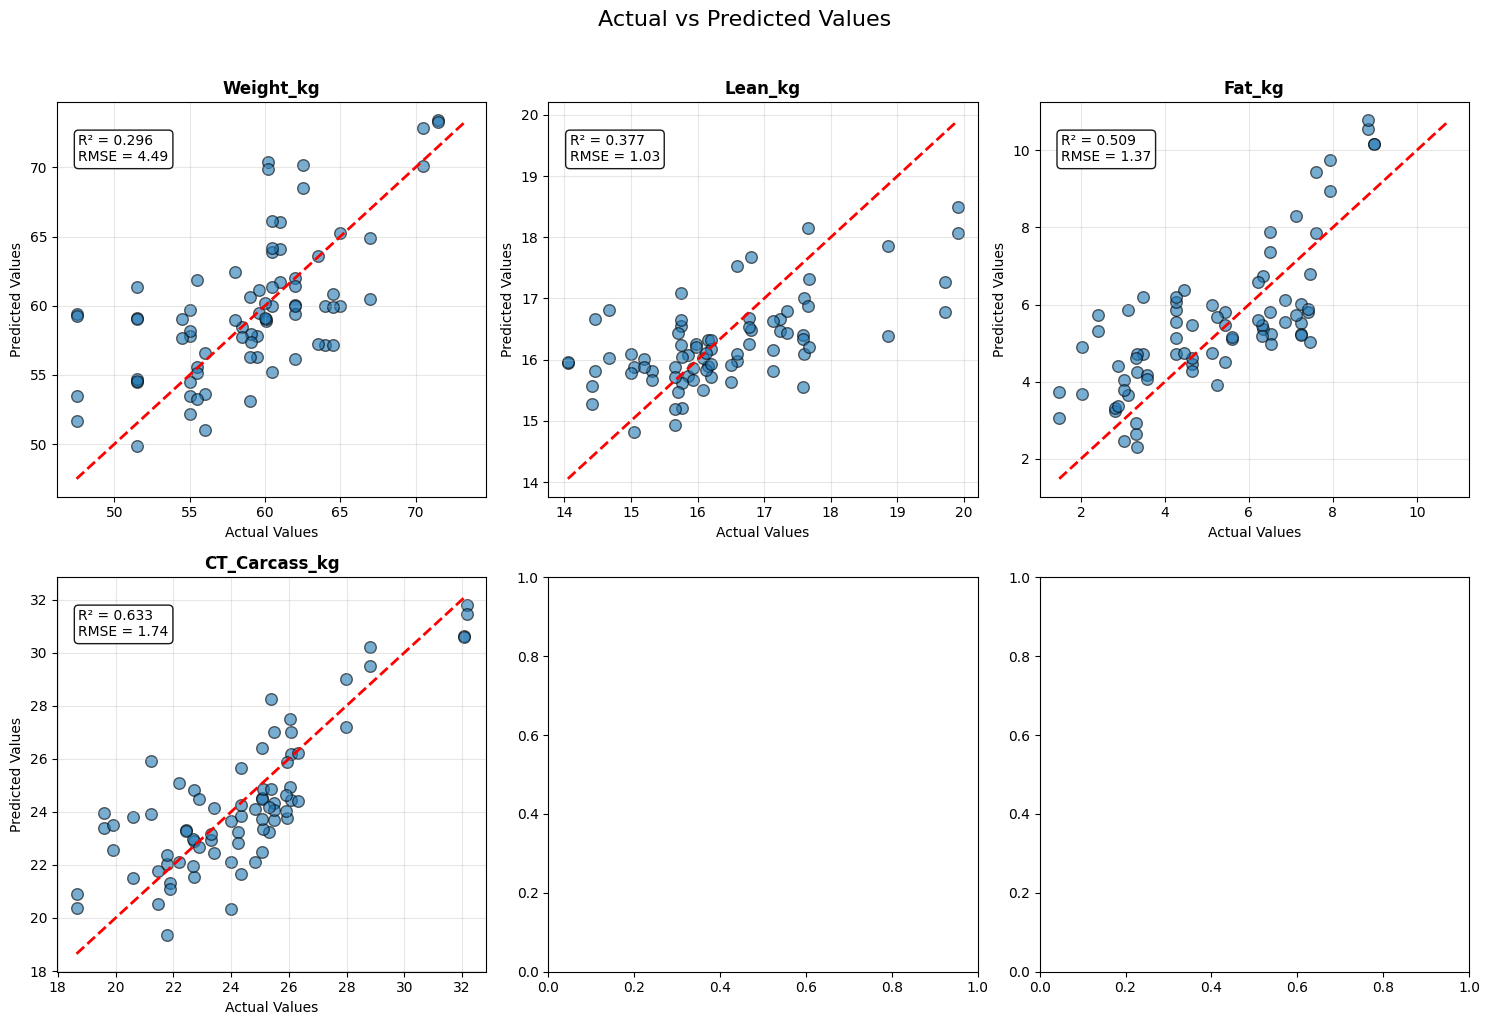


Residual Analysis


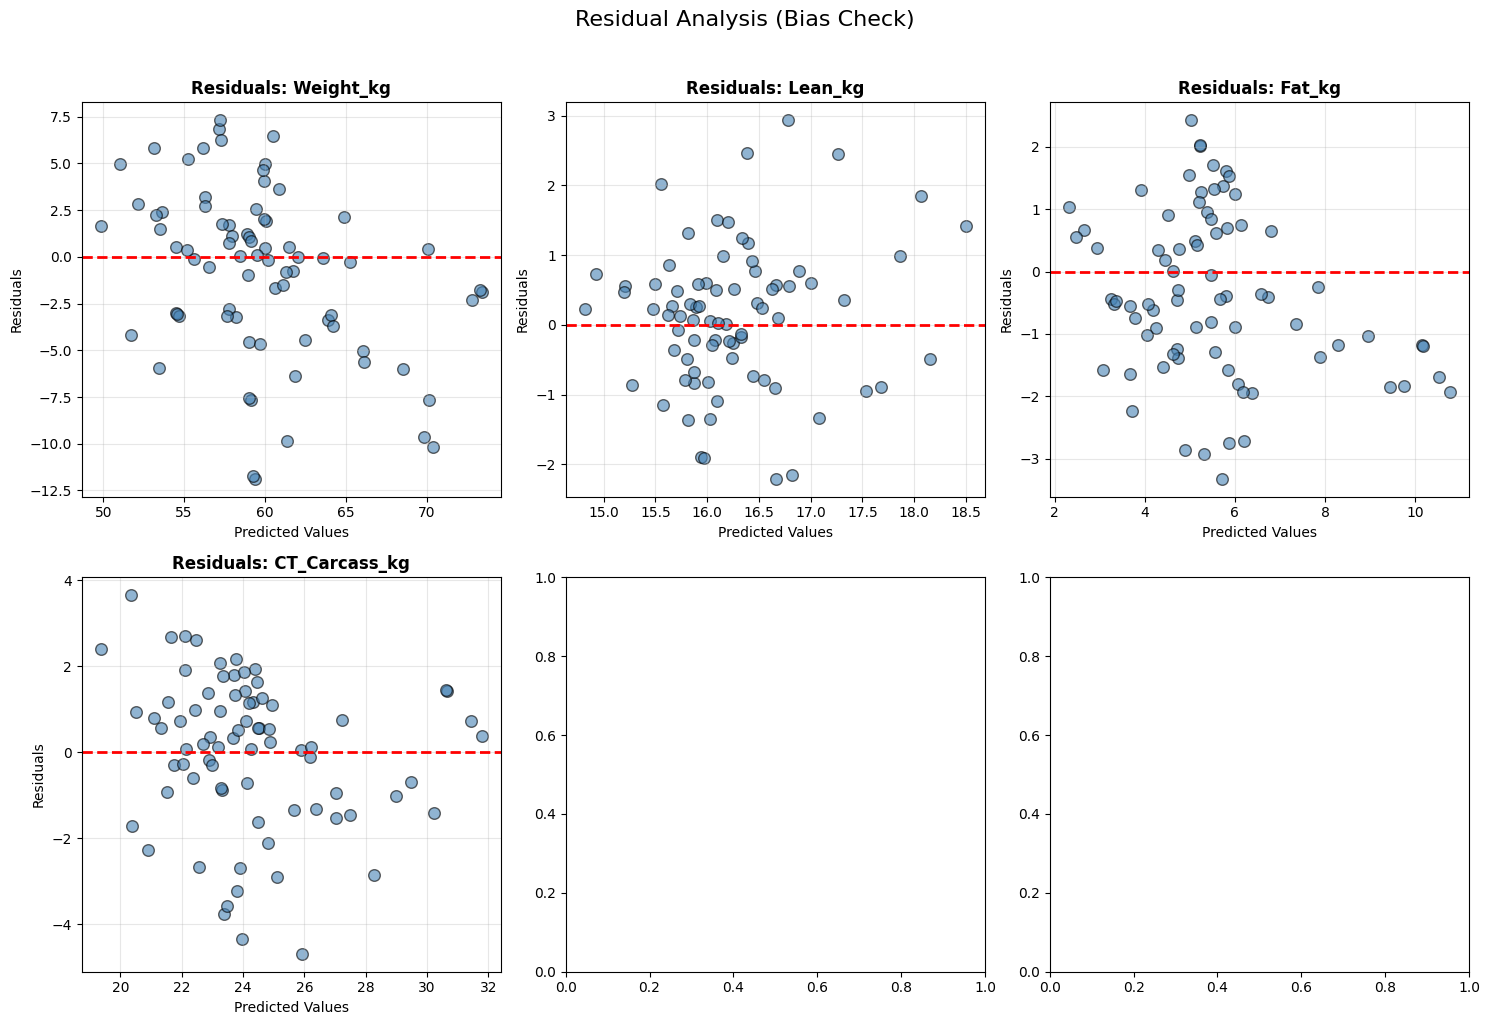


Error Distribution (MAE)


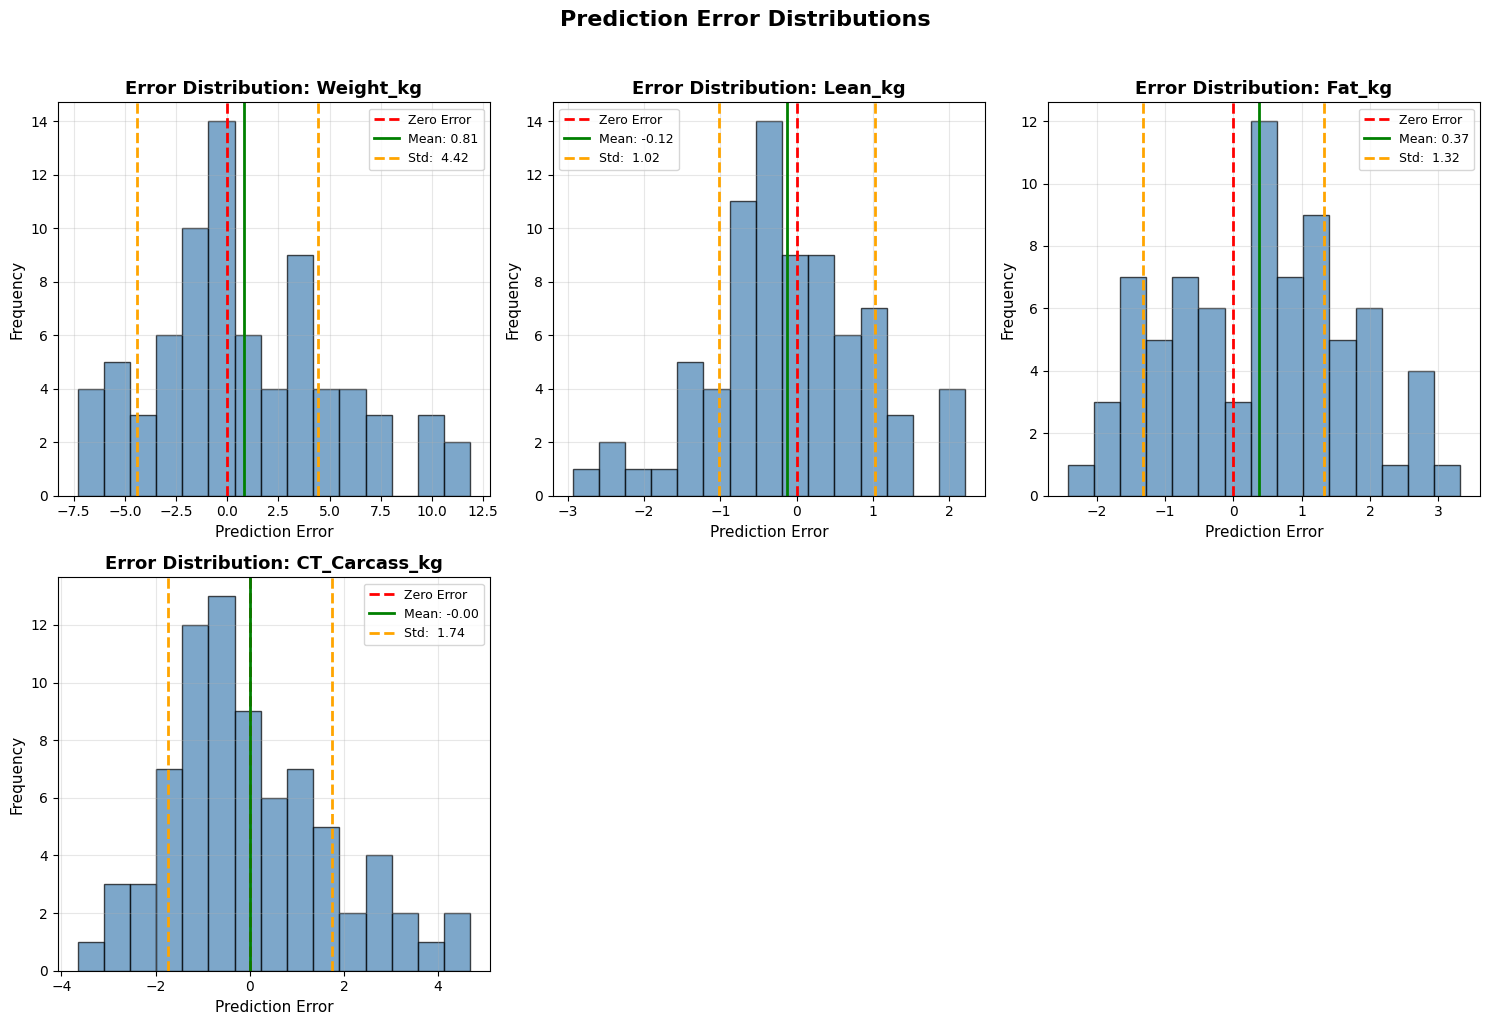


Metrics Summary


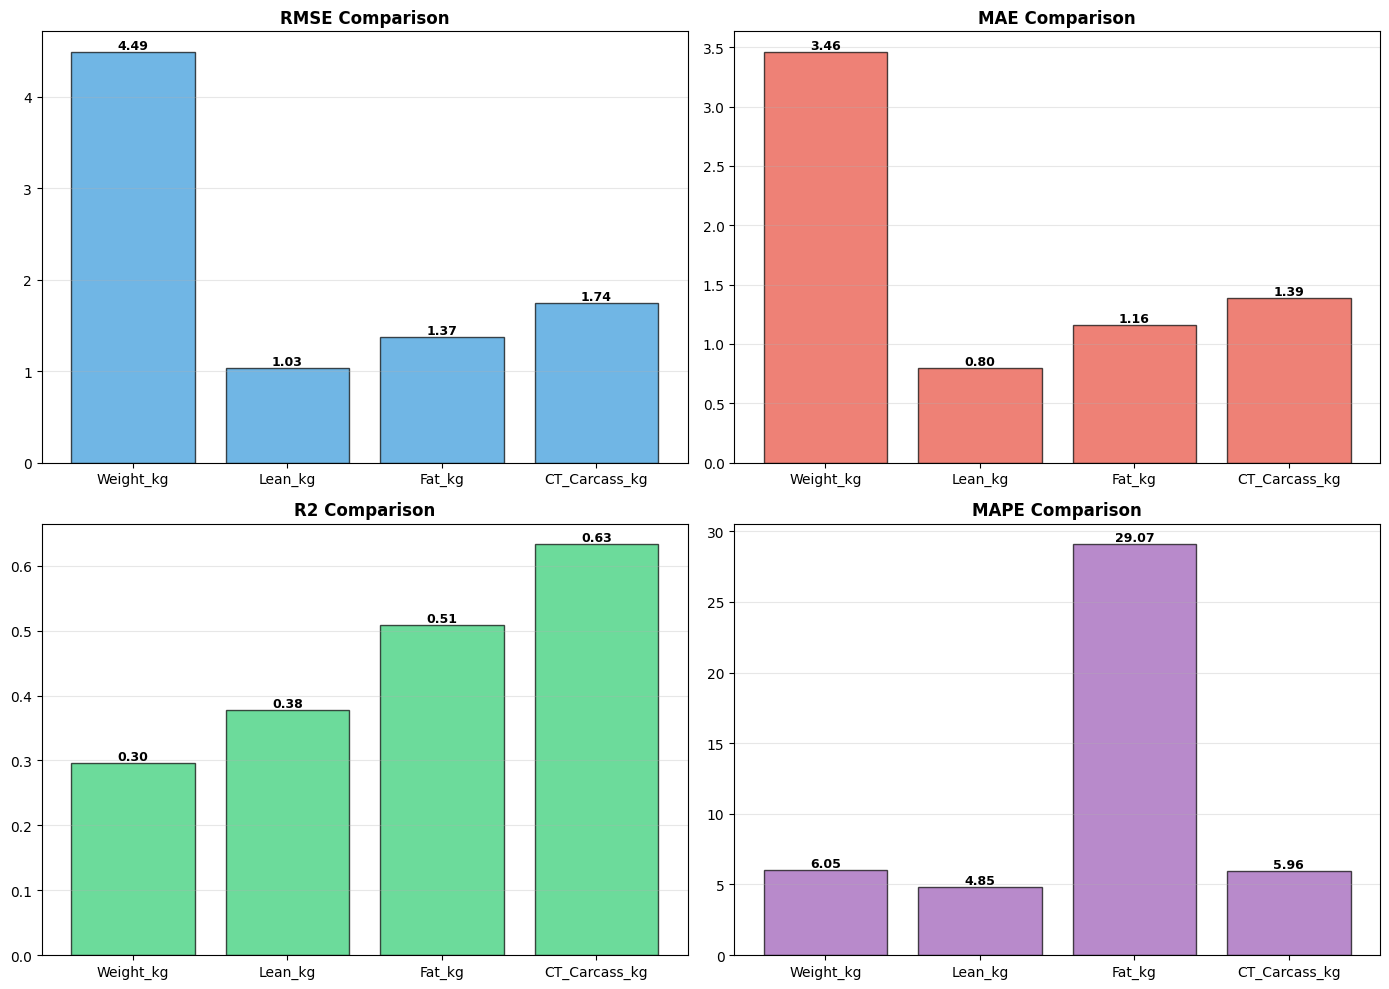


Sample Predictions Table


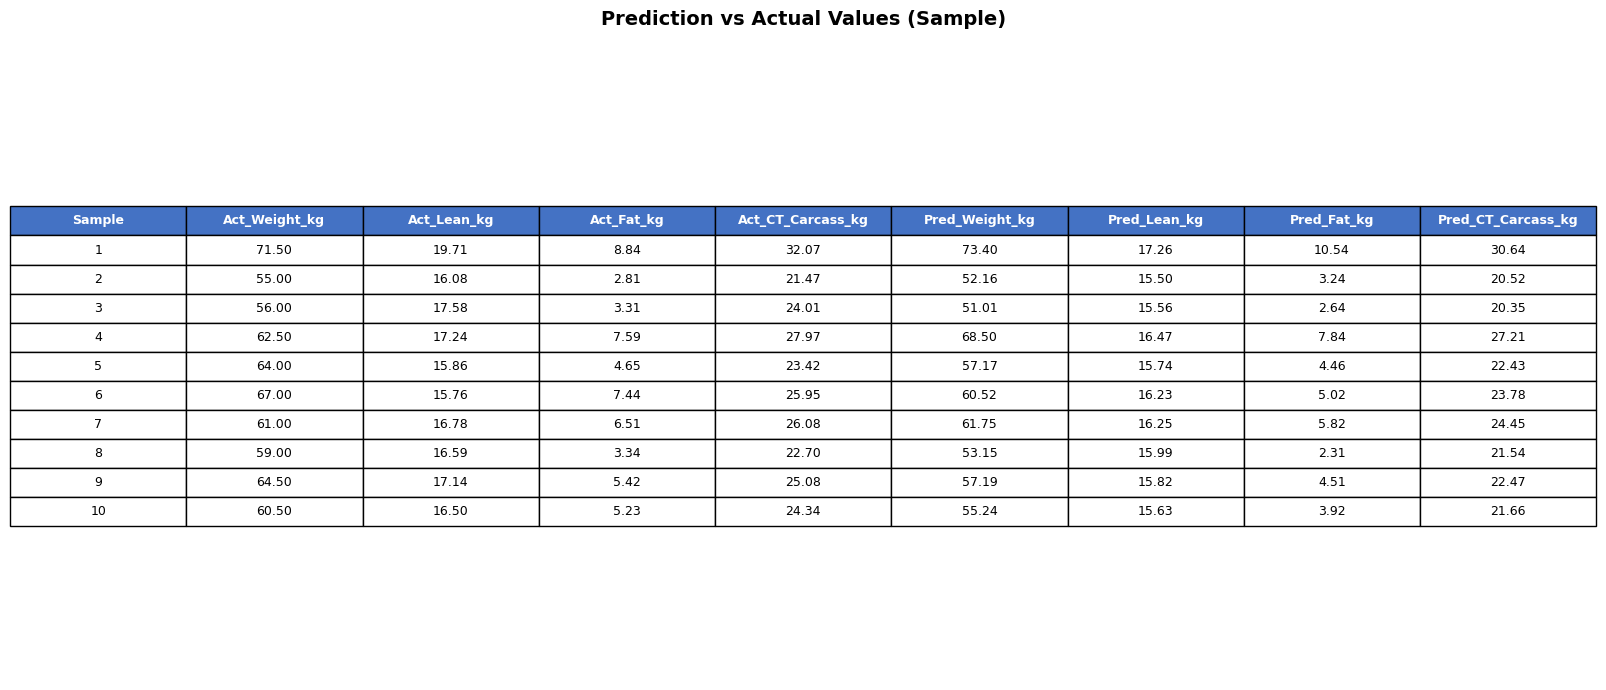


All evaluations complete!


In [ ]:
# --- COMPREHENSIVE MODEL EVALUATION (IMAGE-ONLY FOCUS) ---
print("STARTING COMPREHENSIVE EVALUATION")

# 2. Comprehensive Evaluation (Using the Fine-Tuned Model)
# We use val_loader1 (Image-only loader) and model_stage1
pred_real, actual_real, metrics = comprehensive_evaluation(
    model=trained_model,
    loader=val_dataset_loader,
    scaler=train_dataset.target_scaler,
    target_names=TARGET_COLS,
    device=DEVICE,
    is_hybrid=True
)

# 3. Print Detailed Metrics
print_detailed_metrics(metrics)

# 4. Statistical Visualizations
print("\nRegression Analysis: Actual vs Predicted")
# This shows how close the dots are to the diagonal identity line
plot_prediction_analysis(pred_real, actual_real, UNIFIED_TARGETS)



print("\nResidual Analysis")
# This helps identify if the model consistently overestimates or underestimates
plot_residual_analysis(pred_real, actual_real, UNIFIED_TARGETS)

print("\nError Distribution (MAE)")
# Shows the spread of absolute error in kilograms
plot_error_distribution(pred_real, actual_real, UNIFIED_TARGETS)

print("\nMetrics Summary")
plot_metrics_summary(metrics, UNIFIED_TARGETS)

# 5. Tabular Comparison
print("\nSample Predictions Table")
plot_comparison_table(pred_real, actual_real, UNIFIED_TARGETS, n_samples=10)


print("\nAll evaluations complete!")

In [ ]:
from google.colab import files

print("PREPARING MODEL FOR DOWNLOAD...")

# 1. Define the filename
save_name = 'sheep_resnet18_finetuned.pth'

# 2. Save the comprehensive state
# We use model_stage1 (the fine-tuned version) and train_ds1 scalers
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'target_scaler': train_dataset.target_scaler,
    'target_names': UNIFIED_TARGETS,
    'backbone_type': 'resnet18',
    'metrics': metrics  # The metrics we just calculated in the evaluation cell
}, save_name)

print(f" Model saved locally as {save_name}. Total size: ~45MB")

# 3. Trigger the browser download to your computer
try:
    files.download(save_name)
    print("Download triggered! Check your browser's downloads folder.")
except Exception as e:
    print(f"Browser download failed: {e}")
    print("You can manually download the file from the sidebar 'Files' folder in Colab.")

PREPARING MODEL FOR DOWNLOAD...
 Model saved locally as sheep_resnet18_finetuned.pth. Total size: ~45MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download triggered! Check your browser's downloads folder.
